In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [16]:
X_train.shape

(455, 13)

MSE: 6.5984


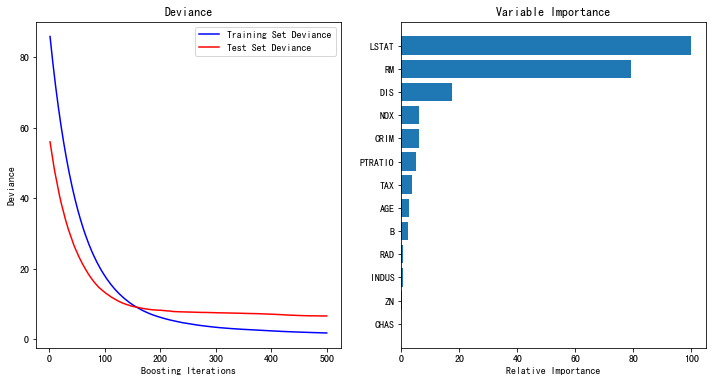

In [4]:
# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [25]:
from treeRegression import CartreeRegression

In [26]:
x_train

array([[1.50234e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.49480e+02, 2.49100e+01],
       [5.44114e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.55290e+02, 1.77300e+01],
       [1.00245e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.80230e+02, 1.19800e+01],
       ...,
       [9.33889e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        6.07200e+01, 2.40800e+01],
       [2.22120e-01, 0.00000e+00, 1.00100e+01, ..., 1.78000e+01,
        3.96900e+02, 1.70900e+01],
       [3.54800e-02, 8.00000e+01, 3.64000e+00, ..., 1.64000e+01,
        3.95180e+02, 9.25000e+00]], dtype=float32)

In [30]:
# coding: utf-8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

In [79]:
class treeNode:
    def __init__(self, label_class=None, feature=None, value=None, right_tree=None, left_tree=None):
        self.feature = feature
        self.value = value
        self.right_tree = right_tree
        self.left_tree = left_tree
        self.label_class = label_class
    
class Tree:
    def __init__(self, min_leafs=5, max_depth=10):
        self.min_leafs = min_leafs
        self.max_depth = max_depth
        
    def binsplitdata(self, data, feature, value):
        left_set = data[data[:, feature] <= value, :]
        right_set = data[data[:, feature] > value, :]
        return left_set, right_set
    
    @classmethod
    def get_deep(cls, model):
        max_deep = 0
        if model.right_tree is not None:
            temp_deep = 1 + cls.get_deep(model.right_tree)
            if temp_deep > max_deep:
                max_deep = temp_deep
        if model.left_tree is not None:
            temp_deep = 1 + cls.get_deep(model.left_tree)
            if temp_deep > max_deep:
                max_deep = temp_deep
        return max_deep

    @classmethod
    def print_leafs(cls, model):
        if model.label_class is not None:
            print("leaf value is {}".format(model.label_class))
        if model.left_tree is not None:
            cls.print_leafs(model.left_tree)
        if model.right_tree is not None:
            cls.print_leafs(model.right_tree)

    @classmethod
    def print_featurevalue(cls, model):
        if model.feature is not None:
            print("feature is {} value is {}".format(model.feature, model.value))
        if model.left_tree is not None:
            cls.print_featurevalue(model.left_tree)
        if model.right_tree is not None:
            cls.print_featurevalue(model.right_tree)

    @classmethod
    def predict_line(cls, model, line):
        """
        预测最好不用 递归的调用
        :param model:
        :param line:
        :return:
        """
        if model.label_class is not None:
            return model.label_class
        split_feature = model.feature
        split_value = model.value
        if line[split_feature] > split_value:
            return cls.predict_line(model.right_tree, line)
        else:
            return cls.predict_line(model.left_tree, line)

    @classmethod
    def predict_line_new(cls, model, line):
        temp = model
        while temp.right_tree or temp.left_tree:
            split_feature = temp.feature
            split_value = temp.value
            if line[split_feature] > split_value:
                temp = temp.right_tree
            else:
                temp = temp.left_tree
        if temp.label_class is not None:
            return temp.label_class
        else:
            return "node is wrong"
        
    @classmethod
    def predict(cls, model, data):
        myre = []
        for line in data:
            te = cls.predict_line_new(model, line)
            myre.append(te)
        myre = np.array(myre).reshape(len(data), 1)
        return myre


class CartreeRegression(Tree):
    def __init__(self, min_leafs=4, max_depth=10, max_bins=10):
        super(CartreeRegression, self).__init__()
        self.min_leafs = min_leafs
        self.max_depth = max_depth

        if isinstance(max_bins, int) and max_bins > 1 and max_bins < 50:
            self.max_bins = max_bins
        else:
            raise ValueError("max_bins is not fit for this model")
        
    def regleaf(self, data, epis=3):
        return np.round(np.mean(data[:, -1]), epis)
    
    def regerr(self, data):
        return np.std(data[:, -1])
    
    def createTree(self, data, depth=0):
        retTree = treeNode()

        if data.shape[0] < self.min_leafs:
            retTree.label_class = self.regleaf(data)
            return retTree

        # 可以添加其他条件,终止树 停止生长，分类和回归树有不同的搞法。
        # 这里阐释了如何 利用递归的思想去 建立决策树
        feat, val = self.choosebestsplit(data)
        # 如果没有可以再次切分的  feature 就返回val
        if feat is None or depth > self.max_depth:
            retTree.label_class = self.regleaf(data)
            return retTree

        # 这里先寻找切分点，然后再切分数据，会好点的
        retTree.feature = feat
        retTree.value = val
        lset, rset = self.binsplitdata(data, feat, val)

        retTree.left_tree = self.createTree(lset, depth=depth+1)
        retTree.right_tree = self.createTree(rset, depth=depth+1)
        return retTree
    
    def choosebestsplit(self, data):
        data = np.array(data)
        m, n = data.shape

        # 计算初始的方差。
        S = self.regerr(data)
        best_s = np.inf
        best_feat = None 
        best_val = None

        for i in range(n-1): # n-1 feature
            # 这么做的好处是 可以加快运行速度，其次可以减少偏态数据的影响，亲测可行
            # ，改善预测效果（方差小偏琦大的问题）
            minx = np.min(data[:, i])
            maxs = np.max(data[:, i])
            step = (maxs - minx) / self.max_bins
            value_set = [minx + i * step for i in range(1, self.max_bins)]
            for j in value_set:
                mat0, mat1 = self.binsplitdata(data, i, j)
                # 控制叶子的数量。不进行控制 进行充分的生长
                new_s = self.regerr(mat0) + self.regerr(mat1)
                if new_s < best_s:
                    best_feat = i
                    best_val = j
                    best_s = new_s
        # 当方差改善不明显时，则停止，没必要进行更新。
        # if S - best_s < 0.001:
        #     return None, None
        return best_feat, best_val

In [80]:
if __name__ == "__main__":
    from sklearn import datasets
    from sklearn.utils import shuffle

    boston = datasets.load_boston()
    X, y = shuffle(boston.data, boston.target, random_state=13)
    X = X.astype(np.float32)
    offset = int(X.shape[0] * 0.9)
    x_train, y_train = X[:offset], y[:offset]
    x_test, y_test = X[offset:], y[offset:]

    y_train = y_train[:, np.newaxis]
    y_test = y_test[:, np.newaxis]

    data = np.concatenate([x_train, y_train], axis=1)
    testdata = np.concatenate([x_test, y_test], axis=1)
    #
    mymodel = CartreeRegression(min_leafs=5, max_bins=10)
    mytree = mymodel.createTree(data)

    la = mymodel.predict(mytree, data)

In [91]:
np.unique(mymodel.predict(mytree, data))

array([ 6.933,  7.833,  8.133, 10.35 , 10.4  , 10.5  , 13.35 , 14.1  ,
       21.1  , 23.133, 25.3  , 30.1  ])

In [82]:
mymodel.print_leafs(mytree)

leaf value is 25.3
leaf value is 10.35
leaf value is 23.133
leaf value is 10.5
leaf value is 7.833
leaf value is 13.35
leaf value is 8.133
leaf value is 21.1
leaf value is 14.1
leaf value is 6.933
leaf value is 30.1
leaf value is 10.4


In [83]:
mytree.label_class

In [84]:
mymodel.predict_line_new(mytree, data[10])

23.133

In [85]:
data[10][-1]

19.6

In [86]:
mytree.left_tree.label_class

In [87]:
data[data[:,0]<80].shape

(454, 14)

In [88]:
np.max(data[:, 0])

88.9761962890625

In [89]:
for lin in data:
    print(predict_line_new(mytree, lin))
    print(lin)
#

right
right
right
right
left
left
right
right
right
right
right
23.133
[1.50234003e+01 0.00000000e+00 1.81000004e+01 0.00000000e+00
 6.14000022e-01 5.30399990e+00 9.73000031e+01 2.10069990e+00
 2.40000000e+01 6.66000000e+02 2.02000008e+01 3.49480011e+02
 2.49099998e+01 1.20000000e+01]
right
right
right
right
left
left
right
right
right
right
right
23.133
[  5.44114017   0.          18.10000038   0.           0.713
   6.65500021  98.19999695   2.35520005  24.         666.
  20.20000076 355.29000854  17.72999954  15.2       ]
right
right
right
right
left
left
right
right
right
right
right
23.133
[  1.00244999   0.           8.14000034   0.           0.53799999
   6.67399979  87.30000305   4.23899984   4.         307.
  21.         380.23001099  11.97999954  21.        ]
right
right
right
right
left
left
right
right
right
right
right
23.133
[6.32000016e-03 1.80000000e+01 2.30999994e+00 0.00000000e+00
 5.37999988e-01 6.57499981e+00 6.51999969e+01 4.09000015e+00
 1.00000000e+00 2.96000000e+

23.133
[1.30099999e-02 3.50000000e+01 1.51999998e+00 0.00000000e+00
 4.42000002e-01 7.24100018e+00 4.92999992e+01 7.03789997e+00
 1.00000000e+00 2.84000000e+02 1.55000000e+01 3.94739990e+02
 5.48999977e+00 3.27000000e+01]
right
right
right
right
left
left
right
right
right
right
right
23.133
[  6.2880702    0.          18.10000038   0.           0.74000001
   6.34100008  96.40000153   2.07200003  24.         666.
  20.20000076 318.01000977  17.79000092  14.9       ]
right
right
right
right
left
left
right
right
right
right
right
23.133
[  0.97617      0.          21.88999939   0.           0.62400001
   5.75699997  98.40000153   2.34599996   4.         437.
  21.20000076 262.76000977  17.30999947  15.6       ]
right
right
right
right
left
left
right
right
right
right
right
23.133
[8.38700011e-02 0.00000000e+00 1.28299999e+01 0.00000000e+00
 4.37000006e-01 5.87400007e+00 3.65999985e+01 4.50260019e+00
 5.00000000e+00 3.98000000e+02 1.87000008e+01 3.96059998e+02
 9.10000038e+00 2.03000000

left
right
right
right
right
right
23.133
[  5.82114983   0.          18.10000038   0.           0.713
   6.51300001  89.90000153   2.80159998  24.         666.
  20.20000076 393.82000732  10.28999996  20.2       ]
right
right
right
right
left
left
right
right
right
right
right
23.133
[  5.20176983   0.          18.10000038   1.           0.76999998
   6.12699986  83.40000153   2.72270012  24.         666.
  20.20000076 395.42999268  11.47999954  22.7       ]
right
right
right
right
left
left
right
right
right
right
right
23.133
[1.90730006e-01 2.20000000e+01 5.86000013e+00 0.00000000e+00
 4.30999994e-01 6.71799994e+00 1.75000000e+01 7.82649994e+00
 7.00000000e+00 3.30000000e+02 1.91000004e+01 3.93739990e+02
 6.55999994e+00 2.62000000e+01]
right
right
right
right
left
left
right
right
right
right
right
23.133
[9.23229980e+00 0.00000000e+00 1.81000004e+01 0.00000000e+00
 6.30999982e-01 6.21600008e+00 1.00000000e+02 1.16910005e+00
 2.40000000e+01 6.66000000e+02 2.02000008e+01 3.66149994e

left
right
right
right
right
right
23.133
[2.14090005e-01 2.20000000e+01 5.86000013e+00 0.00000000e+00
 4.30999994e-01 6.43800020e+00 8.89999962e+00 7.39669991e+00
 7.00000000e+00 3.30000000e+02 1.91000004e+01 3.77070007e+02
 3.58999991e+00 2.48000000e+01]
right
right
right
right
left
left
right
right
right
right
right
23.133
[9.10300016e-02 0.00000000e+00 2.46000004e+00 0.00000000e+00
 4.88000005e-01 7.15500021e+00 9.21999969e+01 2.70059991e+00
 3.00000000e+00 1.93000000e+02 1.77999992e+01 3.94119995e+02
 4.82000017e+00 3.79000000e+01]
right
right
right
right
left
left
right
right
right
right
right
23.133
[4.41699997e-02 7.00000000e+01 2.24000001e+00 0.00000000e+00
 4.00000006e-01 6.87099981e+00 4.74000015e+01 7.82779980e+00
 5.00000000e+00 3.58000000e+02 1.48000002e+01 3.90859985e+02
 6.07000017e+00 2.48000000e+01]
right
right
right
right
left
left
right
right
right
right
right
23.133
[1.91860005e-01 0.00000000e+00 7.38000011e+00 0.00000000e+00
 4.93000001e-01 6.43100023e+00 1.469999

In [57]:
    def predict_line_new(model, line):
        temp = model
        while temp.right_tree or temp.left_tree:
            split_feature = temp.feature
            split_value = temp.value
            if line[split_feature] > split_value:
                temp = temp.right_tree
                print("left")
            else:
                temp = temp.left_tree
                print("right")
        if temp.label_class is not None:
            return temp.label_class
        else:
            return "node is wrong"

In [92]:
a ={"s1":2, "s2":3}
s2 = {"ss":4}

In [94]:
dict(list(a.items()) + list(s2.items()))

{'s1': 2, 's2': 3, 'ss': 4}